In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import time
from itertools import combinations, chain

from scipy.sparse import csr_matrix
from scipy.spatial.distance import cdist
from sklearn.metrics import pairwise_distances

sc.settings.verbosity = 4

In [2]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/HSC/geneformer_adata/merged.anndata.h5ad"

adata = sc.read_h5ad(fpath)
sc.logging.print_memory_usage()
adata.X = csr_matrix(adata.X) 
sc.logging.print_memory_usage()
adata

Memory usage: current 4.11 GB, difference +4.11 GB
Memory usage: current 4.11 GB, difference +0.00 GB


AnnData object with n_obs × n_vars = 166703 × 19311
    obs: 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'cell_type', 'Barcode', 'Library', 'dataset', 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender', 'celltype', 'record_id', 'cell_id', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'seurat_clusters', 'STD.CellType', 'STD_Cat', 'STD_Cat2', 'Sample', 'HLF', 'CRHBP', 'CD34', 'MitoCoverage', 'ClonalGroup', 'Sig.HSC1', 'Sig.Prog1', 'Sig.EarlyE1', 'Sig.LateE1', 'Sig.ProMono1', 'Sig.Mono1', 'Sig.ncMono1', 'Sig.cDC1', 'Sig.pDC1', 'Sig.ProB1', 'Sig.PreB1', 'Sig.B1', 'Sig.Plasma1', 'Sig.T1', 'Sig.CTL1', 'Sig.NK1', 'meanCov', 'ClonalGroup.Prob', 'wsnn_res.0.8', 'Origin.Seurat'
    var: 'gene_name', 'ensemble_id'

In [3]:
adata.obs['cell_type'].value_counts().sort_index()

cell_type
B                          3466
CD4                       11925
CD8                        8376
CLP                        3702
CMP                        2931
EryP                      10788
FB                        26586
GMP                        4984
HSC                       11863
LMPP                        817
LinNegCD34NegCD164high     4434
LinNegCD34NegCD164low       358
LinNegCD34PosCD164Pos      6343
LinNegCD34lowCD164high     4266
MDP                        4273
MEP                        7593
MKP                        4058
MLP                         123
MPP                        9553
Mono                       7251
NK                         4246
Plasma                      727
PreBNK                      592
ProB                       6862
Refined.HSC                9194
cDC                         936
iHSC                       8574
pDC                        1882
Name: count, dtype: int64

# Clean up cell types

In [4]:
cell_type_map = {
    'B': 'B_cell',
    'CD4': 'T_cell',
    'CD8': 'T_cell',
    'CLP': 'CLP',
    'CMP': 'CMP',
    'EryP': 'EryP',
    'FB': 'Fib',
    'GMP': 'GMP',
    'HSC': 'HSC',
    'LMPP': 'LMPP',
    'LinNegCD34NegCD164high': 'LinNeg',
    'LinNegCD34NegCD164low': 'LinNeg',
    'LinNegCD34PosCD164Pos': 'LinNeg',
    'LinNegCD34lowCD164high': 'LinNeg',
    'MDP': 'MDP',
    'MEP': 'MEP',
    'MKP': 'MKP',
    'MLP': 'MLP',
    'MPP': 'MPP',
    'Mono': 'Mono',
    'NK': 'NK',
    'Plasma': 'B_cell',
    'PreBNK': 'PreBNK',
    'ProB': 'B_cell',
    'Refined.HSC': 'HSC',
    'cDC': 'Dendritic_cell',
    'iHSC': 'iHSC',
    'pDC': 'Dendritic_cell',
}

adata.obs['cell_type_standard'] = adata.obs['cell_type'].map(cell_type_map)
adata.obs['cell_type_standard'].value_counts().sort_index()

cell_type_standard
B_cell            11055
CLP                3702
CMP                2931
Dendritic_cell     2818
EryP              10788
Fib               26586
GMP                4984
HSC               21057
LMPP                817
LinNeg            15401
MDP                4273
MEP                7593
MKP                4058
MLP                 123
MPP                9553
Mono               7251
NK                 4246
PreBNK              592
T_cell            20301
iHSC               8574
Name: count, dtype: int64

# Gene set selection

In [5]:
gene_mask, counts = sc.pp.filter_genes(
    adata, 
    min_cells=10, 
    inplace=False,
)

sc.pp.highly_variable_genes(
    adata,
    n_top_genes=5000,
    batch_key='dataset',
    flavor='seurat_v3',
)

selected_genes = adata.var[gene_mask]
print(f"{selected_genes.shape=}")

print(f"Number highly variable genes: {adata.var['highly_variable'].sum()}")

selected_genes.head()

filtered out 362 genes that are detected in less than 10 cells
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
selected_genes.shape=(18949, 8)
Number highly variable genes: 5000


,gene_name,ensemble_id,highly_variable,highly_variable_rank,means,variances,variances_norm,highly_variable_nbatches
gene_name,,,,,,,,
A1BG,A1BG,ENSG00000121410,True,602.0,0.046814,0.098671,0.909736,1
A1CF,A1CF,ENSG00000148584,False,3246.0,0.000630,0.000977,0.913735,2
A2M,A2M,ENSG00000175899,True,1363.5,2.903289,46604.678173,1.566125,8
A2ML1,A2ML1,ENSG00000166535,False,2698.5,0.038596,1.061809,1.070525,4
A3GALT2,A3GALT2,ENSG00000184389,True,1880.0,0.009802,0.011709,0.818573,1


# Normalization

In [6]:
def normalize_per_dataset(adata, dataset_id_key='dataset', target_sum=1e4, layer_name='raw_counts', verbose=True):
    """
    Normalizes each dataset within an AnnData object separately and returns a new AnnData object 
    with the normalized data and raw counts stored in a new layer.

    Args:
        adata: An AnnData object containing multiple datasets.
        dataset_id_key: The key in adata.obs that identifies the dataset for each cell.
        target_sum: The target sum of counts per cell after normalization
        layer_name: The name of the new layer to store the raw counts
        verbose: Whether to print progress messages (default: True)
    
    Returns:
        A new AnnData object with normalized data and raw counts stored in the specified layer
    """

    if verbose:
        print("Starting per-dataset normalization...")

    # Create a copy of the original AnnData object
    new_adata = adata[:, adata.var['highly_variable']].copy()

    # Store the raw counts in a new layer in the new object
    new_adata.layers[layer_name] = new_adata.X.copy()
    if verbose:
        print(f"Raw counts stored in layer '{layer_name}'")

    dataset_ids = new_adata.obs[dataset_id_key].unique()
    num_datasets = len(dataset_ids)

    if verbose:
        print(f"Found {num_datasets} datasets:")
        for dataset_id in dataset_ids:
            print(f"  - {dataset_id}")

    for i, dataset_id in enumerate(dataset_ids):
        if verbose:
            print(f"Normalizing dataset {i+1}/{num_datasets}: '{dataset_id}'")

        idx = new_adata.obs[dataset_id_key] == dataset_id
        subset_data = new_adata[idx, :].copy()

        sc.pp.normalize_total(subset_data, target_sum=target_sum)
        sc.pp.log1p(subset_data)

        new_adata.X[idx, :] = csr_matrix(subset_data.X)

    if verbose:
        print("Normalization complete!")

    return new_adata
        
        
adata = normalize_per_dataset(adata)
adata.layers['norm_log'] = adata.X.copy()
adata

Starting per-dataset normalization...
Raw counts stored in layer 'raw_counts'
Found 9 datasets:
  - iHSC
  - pellin
  - tabula_sapiens
  - young2_HSC
  - young1_all_t2
  - old2_BMMC_HSPC
  - young2_all
  - old1_BMMC_HSPC
  - young1_all_t1
Normalizing dataset 1/9: 'iHSC'
normalizing counts per cell
    finished (0:00:00)
Normalizing dataset 2/9: 'pellin'
normalizing counts per cell
    finished (0:00:00)
Normalizing dataset 3/9: 'tabula_sapiens'
normalizing counts per cell
    finished (0:00:00)
Normalizing dataset 4/9: 'young2_HSC'
normalizing counts per cell
    finished (0:00:00)
Normalizing dataset 5/9: 'young1_all_t2'
normalizing counts per cell
    finished (0:00:00)
Normalizing dataset 6/9: 'old2_BMMC_HSPC'
normalizing counts per cell
    finished (0:00:00)
Normalizing dataset 7/9: 'young2_all'
normalizing counts per cell
    finished (0:00:00)
Normalizing dataset 8/9: 'old1_BMMC_HSPC'
normalizing counts per cell
    finished (0:00:00)
Normalizing dataset 9/9: 'young1_all_t1'
nor

AnnData object with n_obs × n_vars = 166703 × 5000
    obs: 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'cell_type', 'Barcode', 'Library', 'dataset', 'organ_tissue', 'method', 'donor', 'anatomical_information', 'n_counts_UMIs', 'cell_ontology_class', 'free_annotation', 'manually_annotated', 'compartment', 'gender', 'celltype', 'record_id', 'cell_id', 'nCount_RNA', 'nFeature_RNA', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'seurat_clusters', 'STD.CellType', 'STD_Cat', 'STD_Cat2', 'Sample', 'HLF', 'CRHBP', 'CD34', 'MitoCoverage', 'ClonalGroup', 'Sig.HSC1', 'Sig.Prog1', 'Sig.EarlyE1', 'Sig.LateE1', 'Sig.ProMono1', 'Sig.Mono1', 'Sig.ncMono1', 'Sig.cDC1', 'Sig.pDC1', 'Sig.ProB1', 'Sig.PreB1', 'Sig.B1', 'Sig.Plasma1', 'Sig.T1', 'Sig.CTL1', 'Sig.NK1', 'meanCov', 'ClonalGroup.Prob', 'wsnn_res.0.8', 'Origin.Seurat', 'cell_type_standard'
    var: 'gene_name', 

In [7]:
# break

SyntaxError: 'break' outside loop (668683560.py, line 1)

# PCA

computing PCA
    with n_comps=50
    finished (0:00:56)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


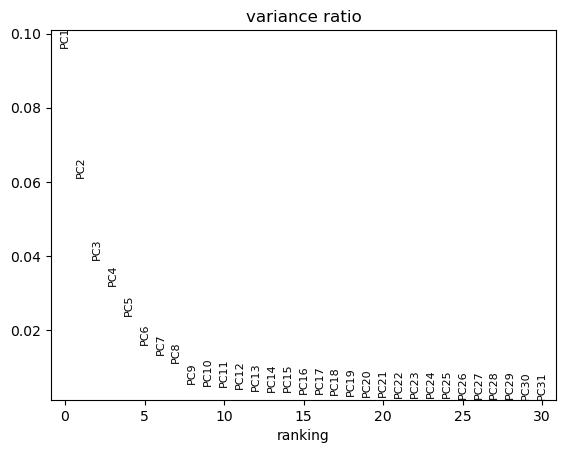

In [8]:
n_comps = 50

sc.pp.pca(
    adata,
    n_comps=n_comps,
    mask_var='highly_variable',
)

sc.pl.pca_variance_ratio(adata)

# Gather matrices

In [9]:
def gather_pca(adata, n_comps=10):
    
    # Convert the data to a sparse CSR matrix
    sparse_matrix = csr_matrix(adata.obsm['X_pca'][:, 0:n_comps])
    
    columns = [f"PC{i+1}" for i in range(n_comps)]

    # Create a sparse DataFrame from the sparse matrix
    sparse_df = pd.DataFrame.sparse.from_spmatrix(
        sparse_matrix,
        index=adata.obs_names,
        columns=columns
    )

    return sparse_df
    

n_comps = 50
total_mem = 0
matrix = {} # for the results
for cell_type, group in adata.obs.groupby('cell_type_standard', observed=True):
    
    group_idx = group.index
    X = gather_pca(adata[group_idx, :], n_comps=n_comps)
    
    memory_usage = X.memory_usage(deep=True).sum() / 1024**3
    total_mem += memory_usage
    
    print(f"{cell_type=} {X.shape=} ({memory_usage:.2f} Gb)")
    matrix[cell_type] = X
    
print('done.')
print(f'Total Mem: {total_mem:.2f} Gb')

cell_type='B_cell' X.shape=(11055, 50) (0.00 Gb)
cell_type='CLP' X.shape=(3702, 50) (0.00 Gb)
cell_type='CMP' X.shape=(2931, 50) (0.00 Gb)
cell_type='Dendritic_cell' X.shape=(2818, 50) (0.00 Gb)
cell_type='EryP' X.shape=(10788, 50) (0.00 Gb)
cell_type='Fib' X.shape=(26586, 50) (0.01 Gb)
cell_type='GMP' X.shape=(4984, 50) (0.00 Gb)
cell_type='HSC' X.shape=(21057, 50) (0.01 Gb)
cell_type='LMPP' X.shape=(817, 50) (0.00 Gb)
cell_type='LinNeg' X.shape=(15401, 50) (0.01 Gb)
cell_type='MDP' X.shape=(4273, 50) (0.00 Gb)
cell_type='MEP' X.shape=(7593, 50) (0.00 Gb)
cell_type='MKP' X.shape=(4058, 50) (0.00 Gb)
cell_type='MLP' X.shape=(123, 50) (0.00 Gb)
cell_type='MPP' X.shape=(9553, 50) (0.00 Gb)
cell_type='Mono' X.shape=(7251, 50) (0.00 Gb)
cell_type='NK' X.shape=(4246, 50) (0.00 Gb)
cell_type='PreBNK' X.shape=(592, 50) (0.00 Gb)
cell_type='T_cell' X.shape=(20301, 50) (0.01 Gb)
cell_type='iHSC' X.shape=(8574, 50) (0.00 Gb)
done.
Total Mem: 0.08 Gb


In [ ]:
# break

# Distances

In [10]:
# metric = 'cosine'
metric = 'euclidean'
results = []

start_time = time.time()  # Start timing the entire process

def get_pairs(items):
    pairs = combinations(items, 2)
    self_loops = [(x, x) for x in items]
    return list(chain(pairs, self_loops))

cell_types = [
    'iHSC',
    'HSC',
    'MEP',
    'MKP',
    'MPP',
    'MLP',
    'Fib',
    'CMP',
    'CLP',
    'GMP',
]

# cell_types = list(matrix.keys())
key_pairs = get_pairs(cell_types)
print(f"Considered comparisons: {len(key_pairs)}")


distances = {}

for i, j in key_pairs:
    Xi = matrix[i]
    Xj = matrix[j]
    
    iter_start_time = time.time()  # Start timing this iteration

    D = pairwise_distances(Xi, Xj, metric=metric)
    # D = pd.DataFrame(D, index=Xi.index, columns=Xj.index)

    iter_end_time = time.time()  # End timing this iteration
    print(f"Iteration ({i}, {j}) took {iter_end_time - iter_start_time:.2f} seconds")

    row = {
        'cell_i': i,
        'cell_j': j,
        'N_i': Xi.shape[0],
        'N_j': Xj.shape[0],
        'mean_distance': np.mean(D),
        'std_distance': np.std(D),
        'median_distance': np.median(D),
        'min_distance': np.min(D),
        'max_distance': np.max(D),
        'seconds' : iter_end_time - iter_start_time,
    }
    results.append(row)
    # break  # Remove this break if you want to process all pairs

results = pd.DataFrame(results)

end_time = time.time()  # End timing the entire process
print(f"Total processing time: {end_time - start_time:.2f} seconds")

results.head()

Considered comparisons: 55
Iteration (iHSC, HSC) took 4.19 seconds
Iteration (iHSC, MEP) took 1.39 seconds
Iteration (iHSC, MKP) took 0.65 seconds
Iteration (iHSC, MPP) took 1.64 seconds
Iteration (iHSC, MLP) took 0.03 seconds
Iteration (iHSC, Fib) took 5.31 seconds
Iteration (iHSC, CMP) took 0.38 seconds
Iteration (iHSC, CLP) took 0.57 seconds
Iteration (iHSC, GMP) took 0.76 seconds
Iteration (HSC, MEP) took 3.69 seconds
Iteration (HSC, MKP) took 1.75 seconds
Iteration (HSC, MPP) took 4.49 seconds
Iteration (HSC, MLP) took 0.08 seconds
Iteration (HSC, Fib) took 13.25 seconds
Iteration (HSC, CMP) took 1.35 seconds
Iteration (HSC, CLP) took 1.52 seconds
Iteration (HSC, GMP) took 2.19 seconds
Iteration (MEP, MKP) took 0.52 seconds
Iteration (MEP, MPP) took 1.49 seconds
Iteration (MEP, MLP) took 0.03 seconds
Iteration (MEP, Fib) took 4.67 seconds
Iteration (MEP, CMP) took 0.33 seconds
Iteration (MEP, CLP) took 0.38 seconds
Iteration (MEP, GMP) took 0.55 seconds
Iteration (MKP, MPP) took 0

,cell_i,cell_j,N_i,N_j,mean_distance,std_distance,median_distance,min_distance,max_distance,seconds
0,iHSC,HSC,8574,21057,59.187969,3.846239,59.663265,19.067745,72.578613,4.190750
1,iHSC,MEP,8574,7593,61.095436,4.830986,61.992905,24.954924,72.912354,1.386922
2,iHSC,MKP,8574,4058,62.496387,3.605956,62.935322,21.874443,73.687607,0.645287
3,iHSC,MPP,8574,9553,59.815159,3.878851,60.222633,27.360458,72.088867,1.638922
4,iHSC,MLP,8574,123,53.799072,3.720968,54.316246,28.851181,63.702801,0.032919


# Visualization

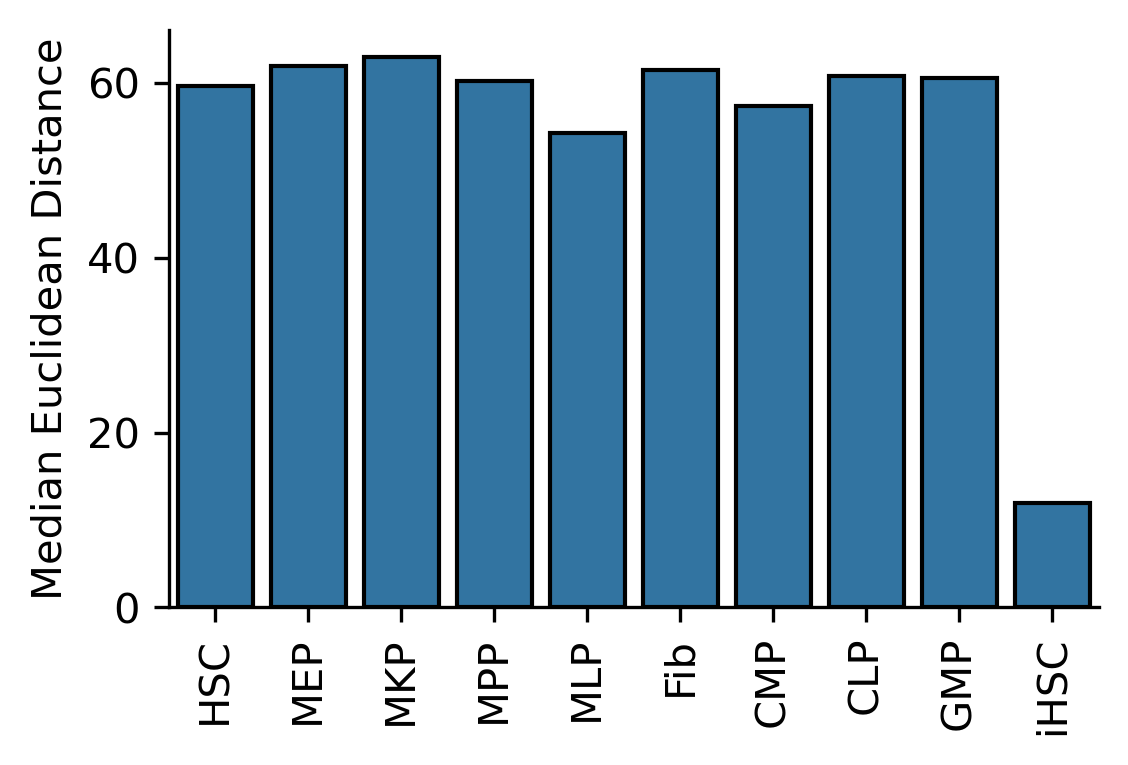

In [13]:
plot = results[results['cell_i'] == 'iHSC']

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 2.5

sns.barplot(
    data=plot,
    x='cell_j',
    y='median_distance',
    ec='k',
)

plt.gca().tick_params(axis='x', rotation=90)
plt.ylabel("Median Euclidean Distance")
plt.xlabel("")

sns.despine()

In [ ]:
# break

# distance matrices

In [ ]:
A = pd.pivot_table(
    results, 
    index='cell_i',
    columns='cell_j',
    values='median_distance',
    fill_value=0,
)

A = (A.T + A) / 2

print(f"{A.shape=}")

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 10, 10

ax = sns.heatmap(
    A,
    square=True,
    linecolor='k',
    lw=1,
    fmt=".3f",
    annot=True,
    # center=True,
    cmap='plasma',
    cbar_kws={'shrink': 0.25, 'label' : f'{metric.title()} Distance'}
)

plt.ylabel("")
plt.xlabel("")

ax.tick_params(axis='y', rotation=0)
    
plt.show()

In [ ]:
break

In [ ]:
break